In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import scanpy as sc
from scipy import sparse

import rpy2.robjects as robjects
from rpy2.robjects import conversion, pandas2ri, default_converter, numpy2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr

import plotly.express as px

In [ ]:
with

In [5]:
from functools import singledispatch

# Functions

In [6]:
@singledispatch
def spearman_rank(df):
    return df.rank(axis=0, ascending=True, na_option="bottom", pct=True)

In [9]:
@spearman_rank.register(sc.AnnData)
def spearman_rank_anndata(adata, inplace=True):
    ranked = pd.DataFrame(adata.X).rank(axis=1, ascending=True, na_option="bottom", pct=True).values
    if inplace:
        adata.X = ranked
    else:
        return ranked

In [11]:
@singledispatch
def variance_partition(X, y, n_procs=4):
    """Compute the variance in X explainable by parameter y."""
    assert isinstance(y, pd.Series)
    
    variancePartition = importr("variancePartition")
    stats = importr("stats")
    doParallel = importr("doParallel")
    parallel = importr("parallel")
    
    cl = parallel.makeCluster(n_procs)
    doParallel.registerDoParallel(cl)

    form = robjects.Formula(f"~ {y.name}")
    ranks = spearman_rank(X)
    target = pd.DataFrame(y)
    
    with localconverter(default_converter + pandas2ri.converter):
        varPart = variancePartition.fitExtractVarPartModel(
            ranks,
            form,
            target
        )

    parallel.stopCluster(cl)
    
    return pd.Series(numpy2ri.rpy2py(varPart[0]), name="Platform_Category", index=X.index)

In [ ]:
blood.to_df

In [12]:
@variance_partition.register(sc.AnnData)
def variance_partition_anndata(adata, y, n_procs=4, inplace=True):
    y_vec = adata.obs[y]
    X = adata.to_df().T
    
    var_part = variance_partition(X, y_vec, n_procs=n_procs)
    
    if inplace:
        adata.var["var_part"] = var_part
    else:
        return var_part

In [4]:
def simulate_bulk(adata, by, skip_groups=(), n_samples=1, n_draws=None):
    """
    Simulate bulk data by summing single cells
    """
    sampled_from = []
    if n_draws is None:
        n_draws = np.inf
    new = pd.DataFrame(index=adata.var_names)
    for key, subdf in adata.obs.groupby(by):
        if key in skip_groups:
            continue
        sampled_from.append(key)
        subset = adata[subdf.index]
        for i in range(n_samples):
            sampled = subset.X[
                np.random.choice(
                    np.arange(len(subset.obs_names)),
                    size=min(n_draws, len(subset.obs_names)), 
                    replace=False)
            ].sum(axis=0)
            new[f"{key}_{i}"] = np.ravel(sampled)
    new_obs = pd.DataFrame(
        {
            by: list(chain.from_iterable(
                repeat(k, n_samples) for k in sampled_from
            )),
        },
        index=new.columns
    )
    if pd.api.types.is_categorical_dtype(adata.obs[by]):
        new_obs[by] = pd.Categorical(new_obs[by], categories=adata.obs[by].cat.categories)
    colorkey = f"{by}_colors"
    if colorkey in adata.uns:
        uns = {colorkey: adata.uns[colorkey]}
    else:
        uns = {}
    return sc.AnnData(new.T, obs=new_obs, uns=uns)

# loading

In [37]:
single_cell = sc.read("../constclust/probably_human.h5ad")
tcga_total = sc.read("../data/tcga.h5ad")
blood = sc.read("../data/blood_atlas.h5ad")

In [42]:
tcga = tcga_total.copy()

# Checking ids

In [93]:
tcga_total.var_names = pd.Series(tcga_total.var_names).apply(lambda x: x.split(".")[0]).values
tcga = tcga_total.copy()

In [33]:
tcga.var_names.isin(blood_sub.var_names).sum()

3668

View of AnnData object with n_obs × n_vars = 1996 × 13093 
    obs: 'case_id', 'primary_site', 'disease_type', 'submitter_id', 'File ID', 'File Name', 'Project ID', 'Case ID', 'Sample ID', 'Sample Type', 'fname'

# Running basic

In [16]:
%%time
variance_partition(blood, "Platform_Category", n_procs=6)


Finished...
Total: 59 s
CPU times: user 55.7 s, sys: 5.17 s, total: 1min
Wall time: 1min 34s


In [88]:
blood_sub = blood[:, blood.var["var_part"] <= .2].copy()

In [89]:
spearman_rank(blood_sub)

In [90]:
sc.pp.pca(blood_sub, n_comps=10)

In [91]:
plotdf = sc.get.obs_df(blood_sub, keys=["celltype"], obsm_keys=[("X_pca", 0), ("X_pca", 1), ("X_pca", 2)])

In [92]:
px.scatter_3d(
    plotdf,
    x="X_pca-0",
    y="X_pca-1",
    z="X_pca-2",
    color="celltype"
)

In [24]:
?blood.concatenate

In [ ]:
def concatenate(adatas, axis=None, dim=None):
    assert axis is not dim
    assert dim is None or axis is None
    

## Adding tcga

In [ ]:
tcga

In [103]:
tcga = tcga[:, blood.var_names.intersection(tcga.var_names)]

In [39]:
tcga.obs

,case_id,primary_site,disease_type,submitter_id,File ID,File Name,Project ID,Case ID,Sample ID,Sample Type,fname
index,,,,,,,,,,,
88f1fd85-f9d8-4bb3-9be9-b96a7dab0ae1,67cf58e9-203e-455a-a25d-5e38d08028bc,Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,TCGA-AB-2874,88f1fd85-f9d8-4bb3-9be9-b96a7dab0ae1,bf2717fa-970f-402a-add8-a589a01b6a6d.FPKM.txt.gz,TCGA-LAML,TCGA-AB-2874,TCGA-AB-2874-03A,Primary Blood Derived Cancer - Peripheral Blood,bf2717fa-970f-402a-add8-a589a01b6a6d.FPKM.txt.gz
590227a3-1155-4531-a60e-c8a10a8f10da,c7afc0d0-ca32-4be1-9477-ad106290c460,Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,TCGA-AB-2939,590227a3-1155-4531-a60e-c8a10a8f10da,267c5ab3-df9c-454e-9f30-2a3ade315ded.FPKM.txt.gz,TCGA-LAML,TCGA-AB-2939,TCGA-AB-2939-03A,Primary Blood Derived Cancer - Peripheral Blood,267c5ab3-df9c-454e-9f30-2a3ade315ded.FPKM.txt.gz
8dadb17d-13af-4272-bb12-edc312880ea4,21bd7197-2504-4710-8c13-a9da9f71b0d5,Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,TCGA-AB-2933,8dadb17d-13af-4272-bb12-edc312880ea4,9b0d4e6c-3439-491f-8f9c-91a497de2c1e.FPKM.txt.gz,TCGA-LAML,TCGA-AB-2933,TCGA-AB-2933-03A,Primary Blood Derived Cancer - Peripheral Blood,9b0d4e6c-3439-491f-8f9c-91a497de2c1e.FPKM.txt.gz
7361f3f6-2e9a-4924-8cf7-449c1b022bbd,3c25d91d-0e1b-46db-a842-06275c5db258,Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,TCGA-AB-2890,7361f3f6-2e9a-4924-8cf7-449c1b022bbd,df22cdca-3659-4fbe-8260-e690da5e58cc.FPKM.txt.gz,TCGA-LAML,TCGA-AB-2890,TCGA-AB-2890-03A,Primary Blood Derived Cancer - Peripheral Blood,df22cdca-3659-4fbe-8260-e690da5e58cc.FPKM.txt.gz
22d65a11-41cd-4059-80b6-e770a7349c82,a45a91f6-55a5-4a5e-ba54-0ac0b4e87d8c,Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,TCGA-AB-2882,22d65a11-41cd-4059-80b6-e770a7349c82,b5abb11d-81a9-43c8-9ad4-7a18bff5d832.FPKM.txt.gz,TCGA-LAML,TCGA-AB-2882,TCGA-AB-2882-03A,Primary Blood Derived Cancer - Peripheral Blood,b5abb11d-81a9-43c8-9ad4-7a18bff5d832.FPKM.txt.gz
754e05b2-d5a7-4c5a-8a66-1198215ab2f3,9dbd2ef7-77da-42ef-90d2-8d30b4330f94,Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,TCGA-AB-2900,754e05b2-d5a7-4c5a-8a66-1198215ab2f3,a363f334-b965-4dd3-a451-34c3562f2adb.FPKM.txt.gz,TCGA-LAML,TCGA-AB-2900,TCGA-AB-2900-03A,Primary Blood Derived Cancer - Peripheral Blood,a363f334-b965-4dd3-a451-34c3562f2adb.FPKM.txt.gz
3d6bfa94-47e1-4650-b213-1af3623f9d2a,96686a1a-16d0-4cdc-b1f7-5dbbf4cf1c9f,Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,TCGA-AB-2819,3d6bfa94-47e1-4650-b213-1af3623f9d2a,57b1805b-7b65-430f-9976-5c654a4fefaf.FPKM.txt.gz,TCGA-LAML,TCGA-AB-2819,TCGA-AB-2819-03A,Primary Blood Derived Cancer - Peripheral Blood,57b1805b-7b65-430f-9976-5c654a4fefaf.FPKM.txt.gz
ef6d9a04-6fe5-4649-9bab-199af729aa4b,3f67b6bc-8886-459a-be73-d702f977a8ba,Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,TCGA-AB-2863,ef6d9a04-6fe5-4649-9bab-199af729aa4b,964269ef-8b6c-4a57-ad80-d8709dbf6397.FPKM.txt.gz,TCGA-LAML,TCGA-AB-2863,TCGA-AB-2863-03A,Primary Blood Derived Cancer - Peripheral Blood,964269ef-8b6c-4a57-ad80-d8709dbf6397.FPKM.txt.gz
b3084d1c-5b32-4c22-b484-3e92250b262c,b147ea90-5643-4680-ac90-d6e8f7166792,Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,TCGA-AB-2859,b3084d1c-5b32-4c22-b484-3e92250b262c,4fd2de09-663c-4452-8cc8-1733a78bf71f.FPKM.txt.gz,TCGA-LAML,TCGA-AB-2859,TCGA-AB-2859-03A,Primary Blood Derived Cancer - Peripheral Blood,4fd2de09-663c-4452-8cc8-1733a78bf71f.FPKM.txt.gz


In [94]:
sc.pp.log1p(tcga)

In [95]:
sc.pp.pca(tcga)
sc.pp.neighbors(tcga, n_neighbors=30)
sc.tl.umap(tcga)

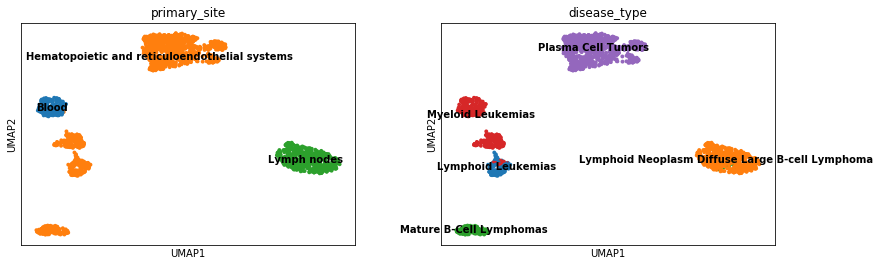

In [68]:
sc.pl.umap(tcga, color=["primary_site", "disease_type"], legend_loc="on data")

In [63]:
sc.tl.embedding_density(tcga, basis="umap", groupby="disease_type")

In [66]:
tcga

AnnData object with n_obs × n_vars = 1996 × 60483 
    obs: 'case_id', 'primary_site', 'disease_type', 'submitter_id', 'File ID', 'File Name', 'Project ID', 'Case ID', 'Sample ID', 'Sample Type', 'fname', 'umap_density_disease_type'
    uns: 'pca', 'primary_site_colors', 'disease_type_colors', 'neighbors', 'umap_density_disease_type_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

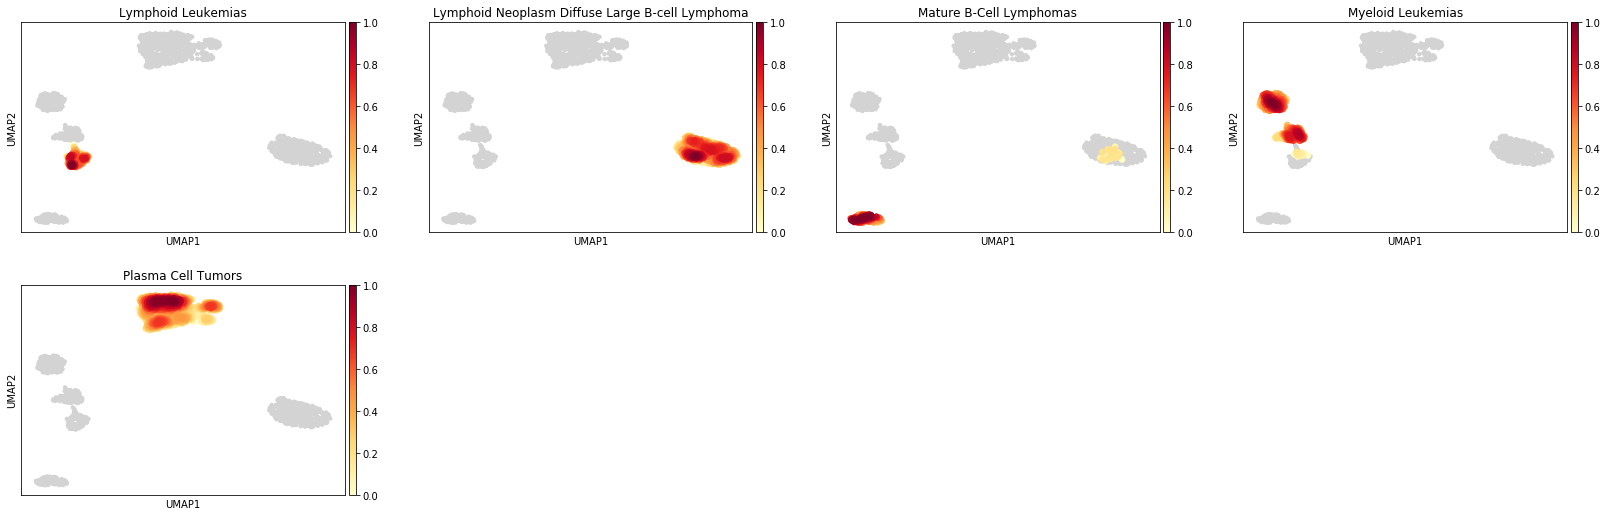

In [67]:
sc.pl.embedding_density(tcga, "umap", "umap_density_disease_type")

In [60]:
?sc.tl.embedding_density

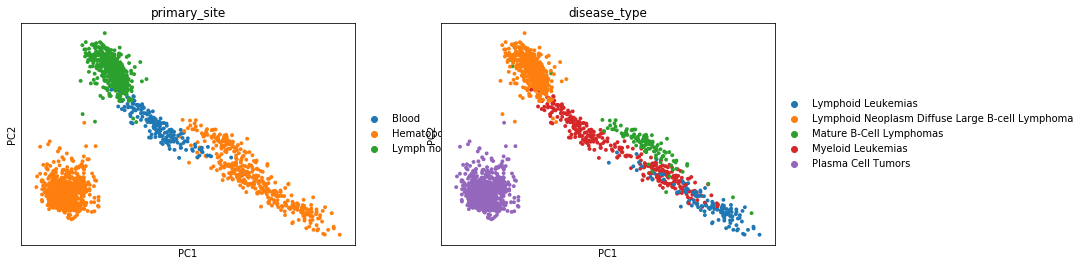

In [56]:
sc.pl.pca(tcga, color=["primary_site", "disease_type"], )

In [41]:
tcga

View of AnnData object with n_obs × n_vars = 1996 × 0 
    obs: 'case_id', 'primary_site', 'disease_type', 'submitter_id', 'File ID', 'File Name', 'Project ID', 'Case ID', 'Sample ID', 'Sample Type', 'fname'

In [69]:
def pca_update(tgt, src, inplace=True):
    # TODO: Make sure we know the settings from src
    if not inplace:
        tgt = tgt.copy()
    if sparse.issparse(tgt.X):
        X = tgt.X.toarray()
    else:
        X = tgt.X.copy()
    X -= np.asarray(tgt.X.mean(axis=0))
    tgt_pca = np.dot(X, src.varm["PCs"])
    tgt.obsm["X_pca"] = tgt_pca
    return tgt

In [96]:
tcga.obs["celltype"] = tcga.obs["disease_type"].astype(str) + "_" + tcga.obs["primary_site"].astype(str)

In [97]:
tcga_sub = tcga[:, blood_sub.var_names].copy()

In [98]:
spearman_rank(tcga_sub)

In [99]:
pca_update(tcga_sub, blood_sub)

AnnData object with n_obs × n_vars = 1996 × 3668 
    obs: 'case_id', 'primary_site', 'disease_type', 'submitter_id', 'File ID', 'File Name', 'Project ID', 'Case ID', 'Sample ID', 'Sample Type', 'fname', 'celltype'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [100]:
tcga_plotdf = sc.get.obs_df(tcga_sub, keys=["celltype"], obsm_keys=[("X_pca", 0), ("X_pca", 1), ("X_pca", 2)])

In [101]:
px.scatter_3d(
    pd.concat([tcga_plotdf, plotdf]),
    x="X_pca-0",
    y="X_pca-1",
    z="X_pca-2",
    color="celltype"
)

In [102]:
tcga = tcga[:, bloo]

AnnData object with n_obs × n_vars = 1996 × 60483 
    obs: 'case_id', 'primary_site', 'disease_type', 'submitter_id', 'File ID', 'File Name', 'Project ID', 'Case ID', 'Sample ID', 'Sample Type', 'fname', 'celltype'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [121]:
def combine(ad1, ad2, batch_keys=("a", "b")):
    assert len(batch_keys) == 2
    shared_var = ad1.var_names.intersection(ad2.var_names)
    ad1 = ad1[:, shared_var].copy()
    ad2 = ad2[:, shared_var].copy()
#     ad1.obs["batch"] = batch_keys[0]
#     ad2.obs["batch"] = batch_keys[1]
    combo = sc.AnnData(
        X=np.append(ad1.X, ad2.X, axis=0),
        obs=pd.concat([ad1.obs, ad2.obs], join="inner")
    )
    return combo

In [117]:
blood.obs_keys


<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 853 × 13095 
    obs: 'tier1', 'tier2', 'tier3', 'celltype', 'display_metadata', 'Dataset', 'dataset_name', 'chip_id', 'replicate_group_id', 'organism', 'sample_type', 'generic_sample_type', 'final_cell_type', 'parental_cell_type', 'sex', 'labelling', 'name', 'description', 'number of samples', 'sample types', 'platform', 'project', 'species', 'Detection threshold', 'Platform_Category', 'Platform_Colour', 'Platform_Symbol'
    var: 'var_part'>

In [158]:
tcga.obs["Platform_Category"] = tcga.obs["Project ID"]
# tcga.obs["Platform_Category"] = "tcga"

In [159]:
combo = combine(tcga, blood)

In [160]:
%%time
variance_partition(combo, "Platform_Category", n_procs=6)


Finished...
Total: 161 s
CPU times: user 3min 14s, sys: 19 s, total: 3min 33s
Wall time: 4min 20s


In [127]:
spearman_rank(combo)

In [128]:
combo

AnnData object with n_obs × n_vars = 2849 × 13093 
    obs: 'celltype', 'Platform_Category'
    var: 'var_part'

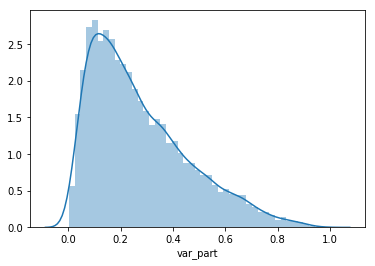

In [129]:
sns.distplot(combo.var["var_part"])

In [131]:
combo_sub = combo[:, combo.var["var_part"] <= .2].copy()

In [134]:
sc.pp.pca(combo_sub, n_comps=10)

In [144]:
plotdf = sc.get.obs_df(combo_sub, keys=["celltype", "Platform_Category"], obsm_keys=[("X_pca", 0), ("X_pca", 1), ("X_pca", 2)])

In [138]:
sc.pp.neighbors(combo_sub)
sc.tl.umap(combo_sub)

/usr/local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



In [143]:
combo_sub

AnnData object with n_obs × n_vars = 2849 × 5710 
    obs: 'celltype', 'Platform_Category'
    var: 'var_part'
    uns: 'pca', 'neighbors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

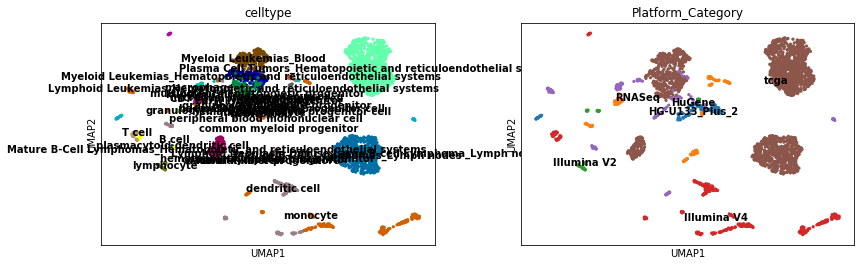

In [145]:
sc.pl.umap(combo_sub, color=["celltype", "Platform_Category"], legend_loc="on data")

In [137]:
px.scatter_3d(
    plotdf,
    x="X_pca-0",
    y="X_pca-1",
    z="X_pca-2",
    color="celltype"
)

In [155]:
px.scatter_3d(
    plotdf,
    x="X_pca-0",
    y="X_pca-1",
    z="X_pca-2",
    color="disease_type"
)

In [154]:
plotdf["primary_site"] = ""
plotdf["disease_type"] = ""
plotdf.loc[tcga.obs_names, "primary_site"] = tcga.obs["primary_site"]
plotdf.loc[tcga.obs_names, "disease_type"] = tcga.obs["disease_type"]

# regressing moar

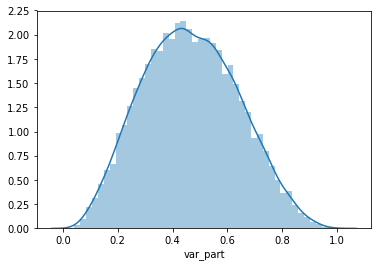

In [161]:
sns.distplot(combo.var["var_part"])

AnnData object with n_obs × n_vars = 2849 × 13093 
    obs: 'celltype', 'Platform_Category'
    var: 'var_part'

In [173]:
# spearman_rank(combo)
combo_sub = combo[:, combo.var["var_part"] <= .3].copy()

In [174]:
spearman_rank(combo_sub)

In [164]:
combo_sub

AnnData object with n_obs × n_vars = 2849 × 7590 
    obs: 'celltype', 'Platform_Category'
    var: 'var_part'

In [180]:
sc.pp.pca(combo_sub)
plotdf = sc.get.obs_df(combo_sub, keys=["celltype", "Platform_Category"], obsm_keys=[("X_pca", 0), ("X_pca", 1), ("X_pca", 2), ("X_pca", 3)])

In [181]:
px.scatter_3d(
    plotdf,
#     x="X_pca-0",
    y="X_pca-1",
    z="X_pca-2",
    x="X_pca-3",
    color="celltype",
    hover_data=["celltype", "Platform_Category"]
)

In [186]:
sc.pp.neighbors(combo_sub, n_neighbors=30)
sc.tl.umap(combo_sub)

/usr/local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)



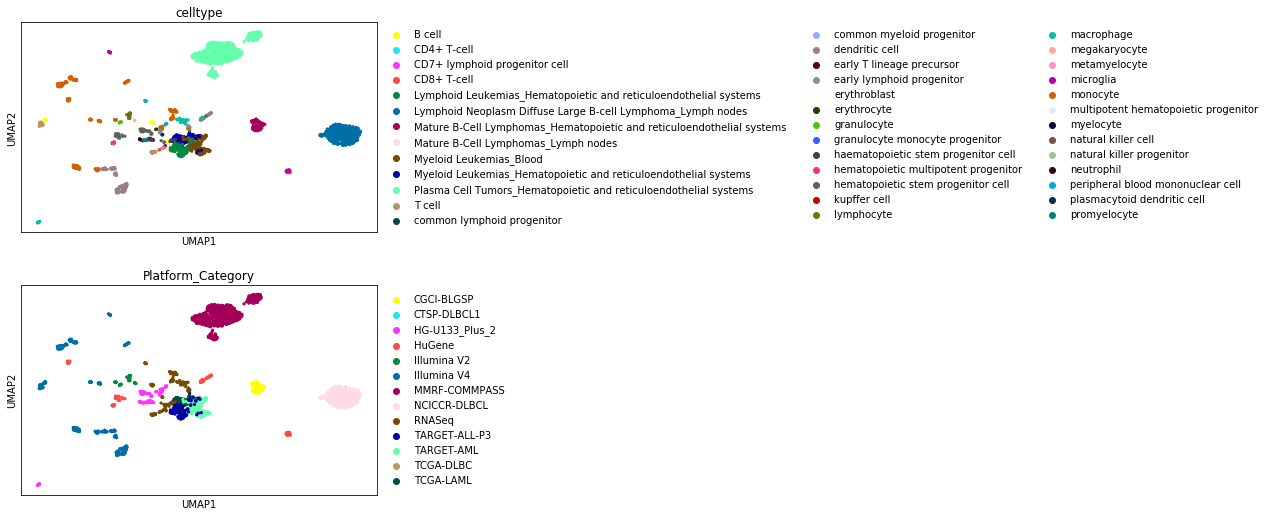

In [187]:
sc.pl.umap(combo_sub, color=["celltype", "Platform_Category"], ncols=1, palette=sc.pl.palettes.godsnot_64)

In [ ]:
sim = simulate_bulk(single_cell)

In [189]:
tcga_lymph = tcga[tcga.obs["celltype"].str.lower().str.contains("lymph")].copy()